##### TP integrador
Download Dataset here:
[Buenos Aires public bike system](https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import pacf
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg



In [3]:
HTML('<a href="https://www.kaggle.com/datasets/fgarciablanco/buenos-aires-public-bike-system-dataset?resource=download" target="_blank">Download Dataset</a>')

### EDA

In [4]:
df = pd.read_csv('./Datasets/recorridos-realizados-2018.csv', encoding='latin-1')
len(df)

1457509

In [5]:
df.head(5)
#df.info()

,bici_id_usuario,bici_Fecha_hora_retiro,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_direccion,bici_pais
0,15728,26/05/2018 15:32:07,0:08:52,F. J. Santamaría de Oro,125,Acuña de Figueroa,54,M,28.0,TTE BENJAMIN MATIENZO,Argentina
1,26531,26/05/2018 3:42:41,0:30:49,Yatay,121,Hospital Garrahan,107,M,26.0,LAVALLE,Argentina
2,161323,26/05/2018 18:52:19,0:12:00,Aime Paine,151,Retiro II,130,M,44.0,olga cossettini,NaN
3,239148,26/05/2018 13:19:34,1:26:30,Galerías Pacífico,34,Juana Manso,26,M,36.0,larrea,NaN
4,260323,26/05/2018 8:41:53,0:11:29,Virrey Cevallos,183,Corrientes,132,M,26.0,chacabuco,NaN


In [6]:
# Convertir fecha_hora_retiro a datetime

df.bici_Fecha_hora_retiro = df.bici_Fecha_hora_retiro.apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M:%S'))
df['date'] = df.bici_Fecha_hora_retiro.apply(lambda x: x.replace(minute=0, second=0))

Text(0.5, 1.0, 'Alquiler de bicis Mayo 2015 - Julio 2018 (agrupado por fecha/hora)')

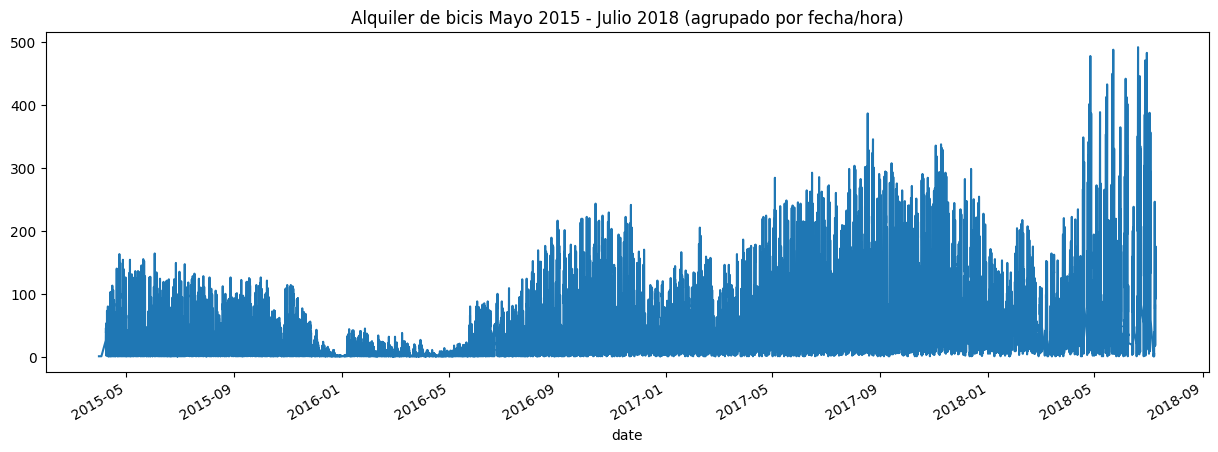

In [9]:
plt.figure(figsize=(15,5))
df.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Mayo 2015 - Julio 2018 (agrupado por fecha/hora)')

#### Limpieza de datos

Observamos que hay muchos menos registros durante los primeros meses de 2016. Es por esta razón que tomaremos la decisión de achicar la serie y quedarnos con dos años de datos, desde Julio 2016 a Julio 2018.

In [10]:
fecha_limite = pd.to_datetime('2016-08-01 00:00:00')
df_shorten = df[df['date'] >= fecha_limite].copy()
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count().resample('D').sum()

Text(0.5, 1.0, 'Alquiler de bicis Agosto 2016 - Julio 2018 (agrupado por fecha/hora)')

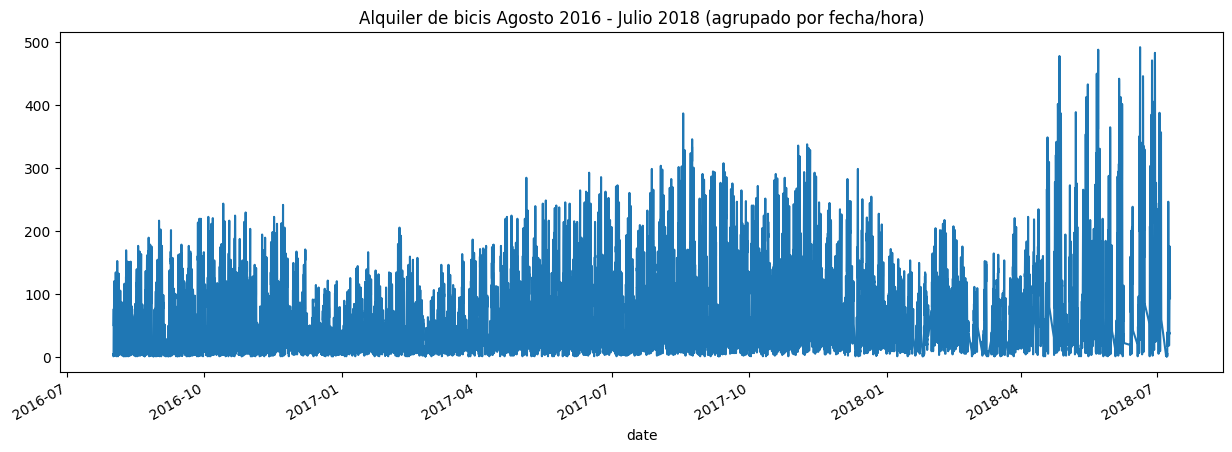

In [12]:
plt.figure(figsize=(15,5))
df_shorten.groupby('date').bici_id_usuario.count().plot()
plt.title('Alquiler de bicis Agosto 2016 - Julio 2018 (agrupado por fecha/hora)')

In [13]:
# Obtengo minutos de alquiler de bici

parse_duration = lambda duration_str: timedelta(
    hours=int(duration_str.split(':')[0]),
    minutes=int(duration_str.split(':')[1]) if len(duration_str.split(':')) >=2 else 0,
    seconds=int(duration_str.split(':')[2]) if len(duration_str.split(':')) >=3 else 0
)

df_shorten['bici_tiempo_uso_delta'] = df_shorten['bici_tiempo_uso'].apply(lambda x: parse_duration(x))
df_shorten['total_minutes'] = df_shorten['bici_tiempo_uso_delta'].dt.total_seconds() / 60

In [14]:
min(df_shorten.total_minutes), max(df_shorten.total_minutes)

(8.0, 1756.9166666666667)

Text(0.5, 1.0, 'Boxplot: duración de alquiler de bici (excluyendo outliers)')

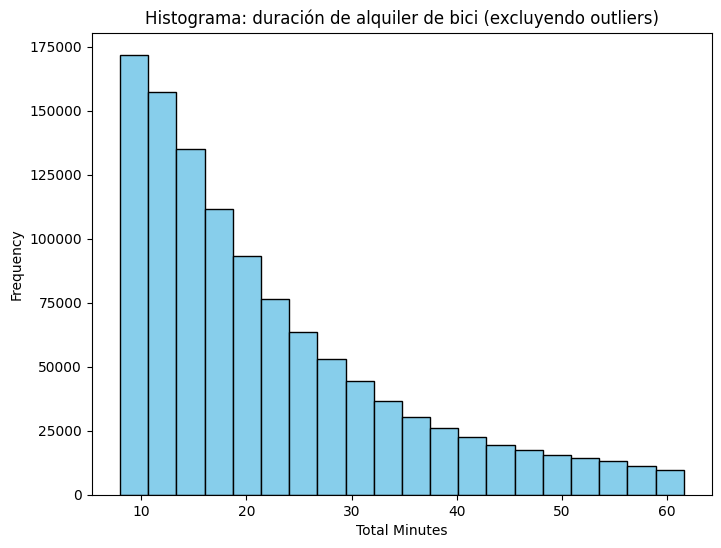

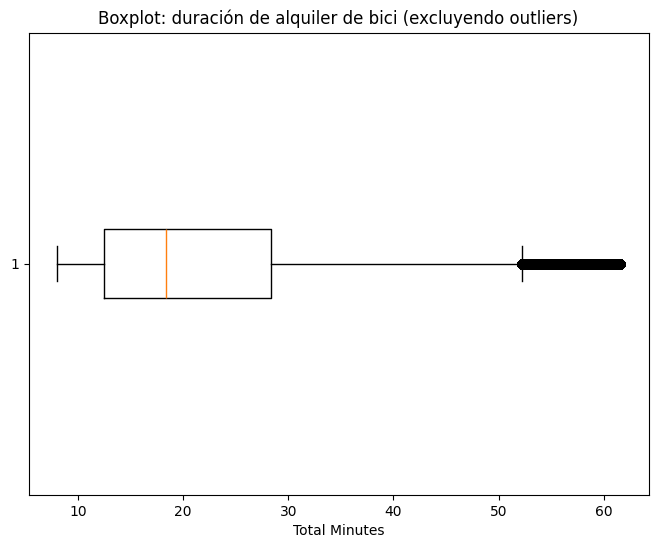

In [15]:
# Calculo quantiles
Q1 = df_shorten['total_minutes'].quantile(0.25)
Q3 = df_shorten['total_minutes'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtramos outliers
filtered_df = df_shorten[(df_shorten['total_minutes'] >= lower_bound) & (df_shorten['total_minutes'] <= upper_bound)]

plt.figure(figsize=(8, 6))
plt.hist(filtered_df['total_minutes'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.title('Histograma: duración de alquiler de bici (excluyendo outliers)')

plt.figure(figsize=(8, 6))
plt.boxplot(filtered_df['total_minutes'], vert=False)
plt.xlabel('Total Minutes')
plt.title('Boxplot: duración de alquiler de bici (excluyendo outliers)')


##### **Observación**
A partir del histograma observamos que la gran mayoría de los usuarios alquilan las bicicletas por períodos cortos menores a una hora. La mediana de uso está alrededor de los 20 minutos. 

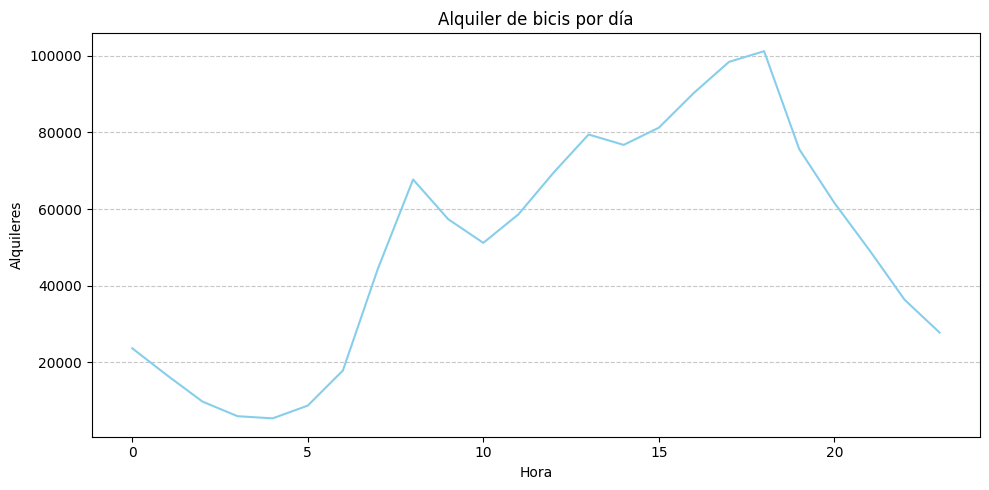

In [16]:
df_shorten['hour'] = df_shorten['date'].dt.hour
hourly_rentals = df_shorten.groupby('hour')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
hourly_rentals.plot( color='skyblue')
plt.title('Alquiler de bicis por día')
plt.xlabel('Hora')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


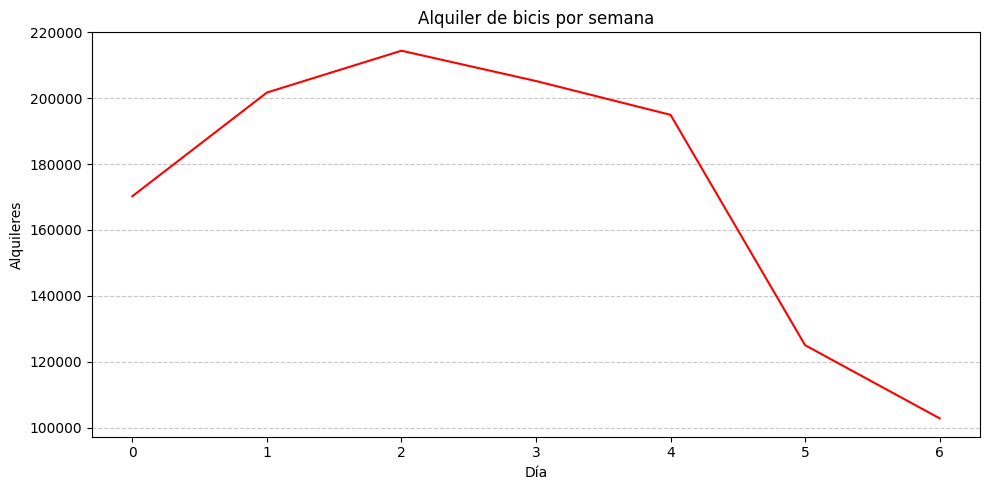

In [17]:
df_shorten['dia'] = df_shorten['date'].dt.weekday
weekly_rentals = df_shorten.groupby('dia')['bici_id_usuario'].count()

plt.figure(figsize=(10, 5))
weekly_rentals.plot( color='red')
plt.title('Alquiler de bicis por semana')
plt.xlabel('Día')
plt.ylabel('Alquileres')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


##### **Observación**

De estos gráficos se desprende que:
* de lunes a viernes hay más alquileres de bicis que durante los fines de semana. 
* Por otro lado, hay tres picos de alquileres a las 9 am, al mediodía y alrededor de las 18, lo que coincide con los horarios en que la mayoría de la gente va y vuelve de trabajar.
* La serie presenta valles en las horas no pico, con una drástica caída durante la madrugada.

#### 1 mes vs 6 meses de datos

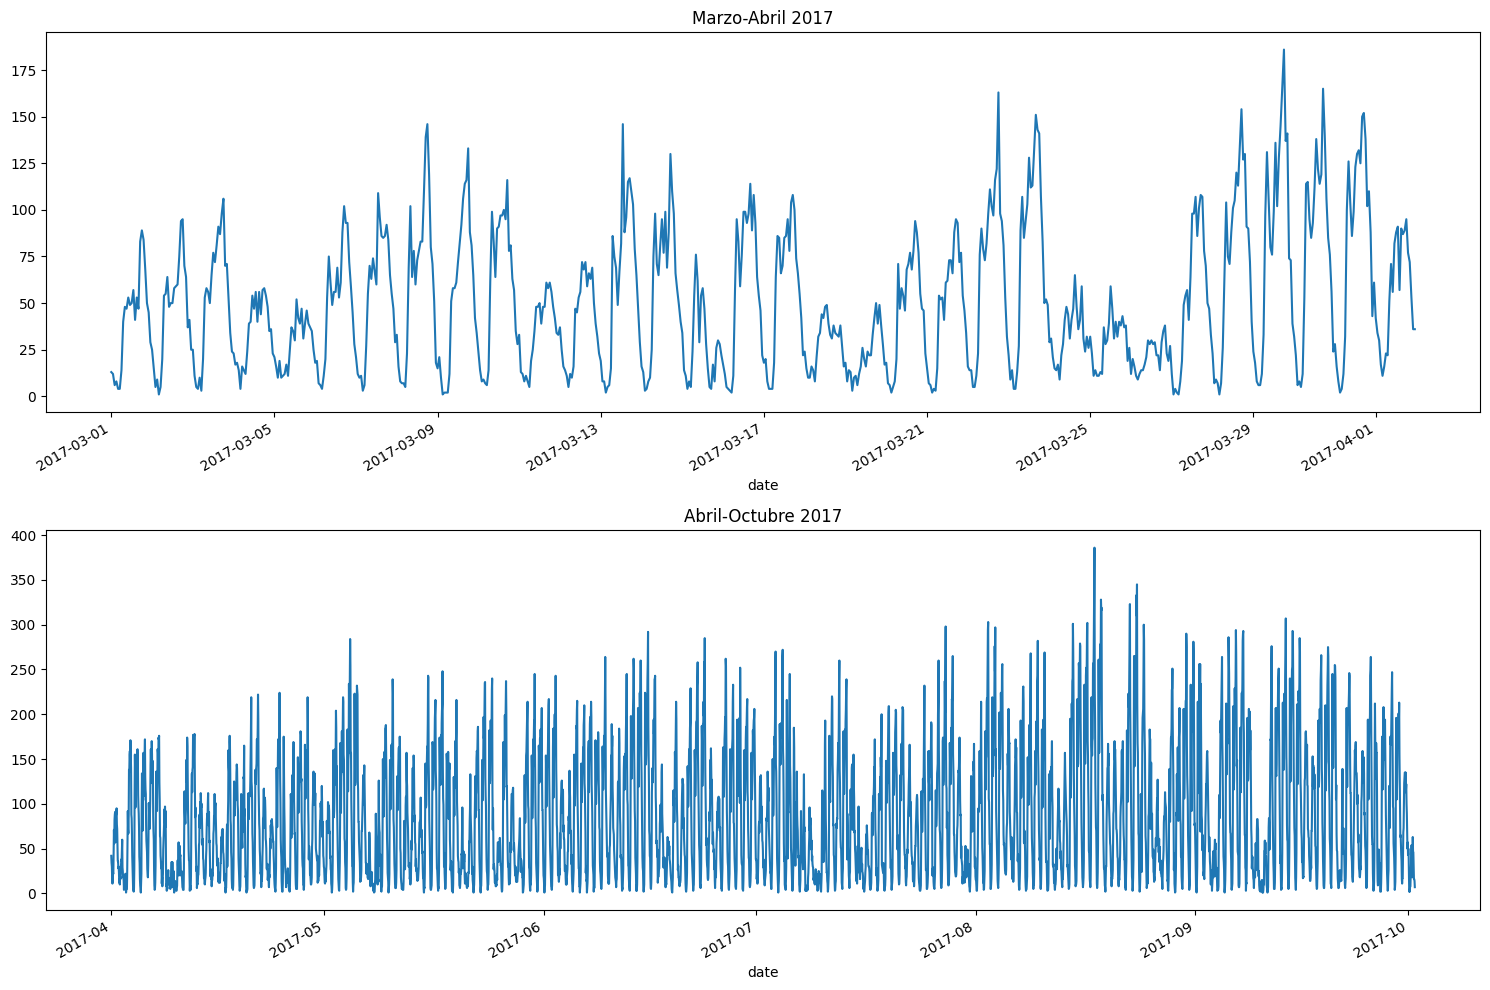

In [19]:
s = df.groupby('date').bici_id_usuario.count()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))

## Visualización un mes de datos
s['2017-03-01': '2017-04-01'].plot(ax=axes[0])
axes[0].set_title('Marzo-Abril 2017')

# Visualización 6 meses de datos
s['2017-04-01': '2017-10-01'].plot(ax=axes[1])
axes[1].set_title('Abril-Octubre 2017')

plt.tight_layout()
plt.show()

##### **Observacion**
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.

#### Tiempo de uso del servicio

In [22]:
# Nos quedamos con la mediana 

rental_duration = df_shorten.groupby(pd.Grouper(key='date', freq='D'))['total_minutes'].median().reset_index()
rental_duration = rental_duration.set_index('date')
rental_duration.isna().sum()

total_minutes    36
dtype: int64

In [23]:
rental_duration = rental_duration.dropna()
rental_duration = rental_duration[rental_duration.total_minutes < 1000]

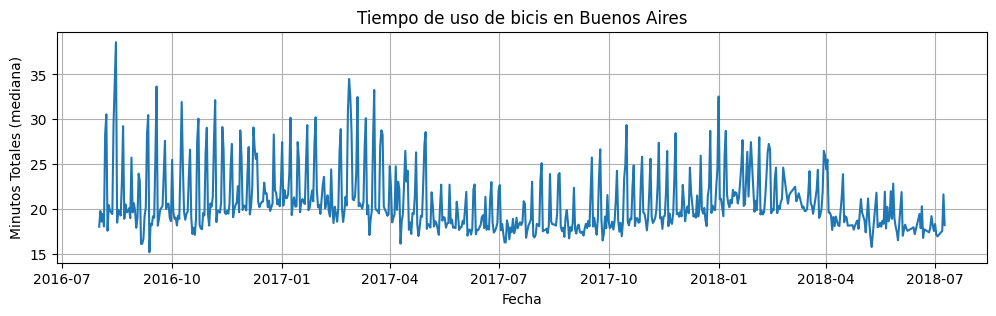

In [24]:
plt.figure(figsize=(12, 3))
plt.plot(rental_duration.index, rental_duration['total_minutes'])
plt.title('Tiempo de uso de bicis en Buenos Aires')
plt.xlabel('Fecha')
plt.ylabel('Minutos Totales (mediana)')
plt.grid(True)

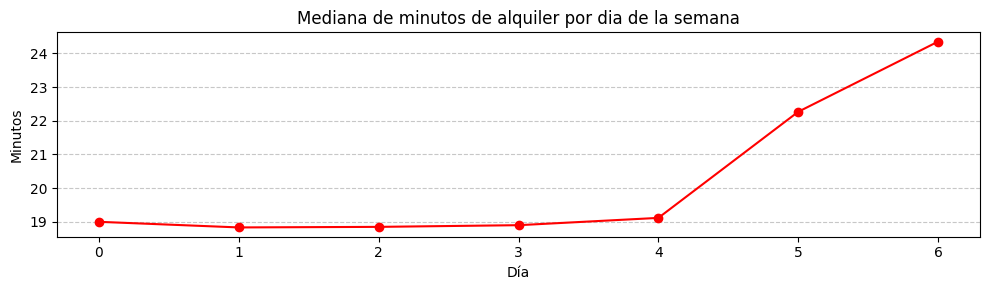

In [25]:
df_shorten['dia'] = df_shorten['date'].dt.weekday
weekly_minutes = df_shorten.groupby('dia')['total_minutes'].median()

plt.figure(figsize=(10, 3))
weekly_minutes.plot( color='red', marker="o")

plt.title('Mediana de minutos de alquiler por dia de la semana')
plt.xlabel('Día')
plt.ylabel('Minutos')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

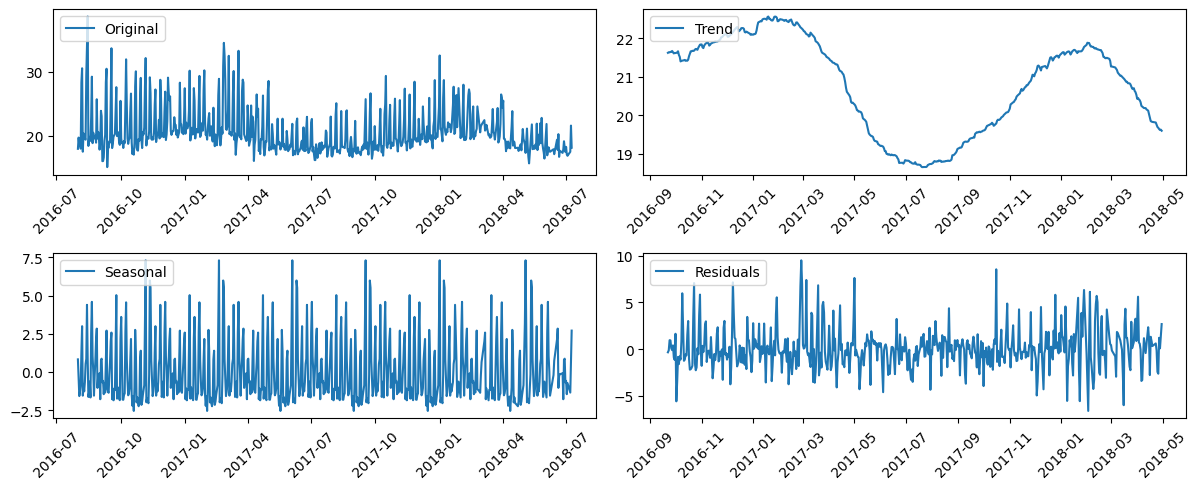

In [26]:
minutes_decompose = seasonal_decompose(rental_duration['total_minutes'], model='additive', period=7*15)

plt.figure(figsize=(12, 5))

plt.subplot(221)
plt.plot(rental_duration['total_minutes'], label='Original')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(222)
plt.plot(minutes_decompose.trend, label='Trend')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(223)
plt.plot(minutes_decompose.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.xticks(rotation=45)

plt.subplot(224)
plt.plot(minutes_decompose.resid, label='Residuals')
plt.legend(loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### **Observación** 

En estos gráficos podemos observar que:
* Hay una tendencia creciente en el tiempo de uso de la bicicleta a partir de noviembre, que coincide con los meses de verano. 
* Si bien, tal como vimos en los otros gráficos, cae el alquiler durante esos meses, al parecer los usuarios que usan las bicicletas lo hacen por períodos de tiempo más largos.
* Hay una tendencia decreciente durante los meses de invierno, esto es, los usuarios pasan menos tiempo arriba de la bicicleta. 

#### Conclusiones parciales EDA
El dataset contiene información sobre el alquiler de bicicletas en la Ciudad de Buenos Aires durante el período Marzo 2015 - Julio 2018.

* En el gráfico de toda la serie se observa una tendencia creciente a partir del 2016 con dos valles marcados durante los meses de enero y febrero de 2017 y 2018 que coinciden con los meses donde la mayor cantidad de gente suele estar de vacaciones. 
La tendencia creciente podría deberse a un incremento en la adopción del servicio de alquiler de bicis.
* Se trata de una serie univariada y discreta 
* Graficamos también por día de la semana y por hora. Se observa cómo decae el alquiler durante los fines de semana y cómo la mayor cantidad de alquileres se da entre las 08 y las 20 horas, con un pico a las 18/19 horas. Esto coincide con el horario en que la gente entra y sale de trabajar. Mientras que el alquiler cae drásticamente durante las horas de la madrugada.
* Graficando un mes de datos podemos observar cierta estacionalidad dada por los picos y valles entre semanas. 
* Graficando seis meses de datos en el período de Abril 2017 - Octubre 2017 vemos que la estacionalidad se mantiene.
* A partir del histograma observamos que la gran mayoría de los usuarios alquilan las bicicletas por períodos cortos menores a una hora. La mediana de uso está alrededor de los 20 minutos.
* Hay una tendencia creciente en el tiempo de uso de la bicicleta a partir de noviembre, que coincide con los meses de verano. 
* Si bien, tal como vimos en los otros gráficos, cae el alquiler durante los meses de verano, al parecer los usuarios que usan las bicicletas lo hacen por períodos de tiempo más largos.
* Hay una tendencia decreciente durante los meses de invierno, esto es, los usuarios pasan menos tiempo arriba de la bicicleta. 

### Modelo aditivo de cuatro componentes 
A partir de la cantidad de usuario por día

In [ ]:
rents = df_shorten.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()

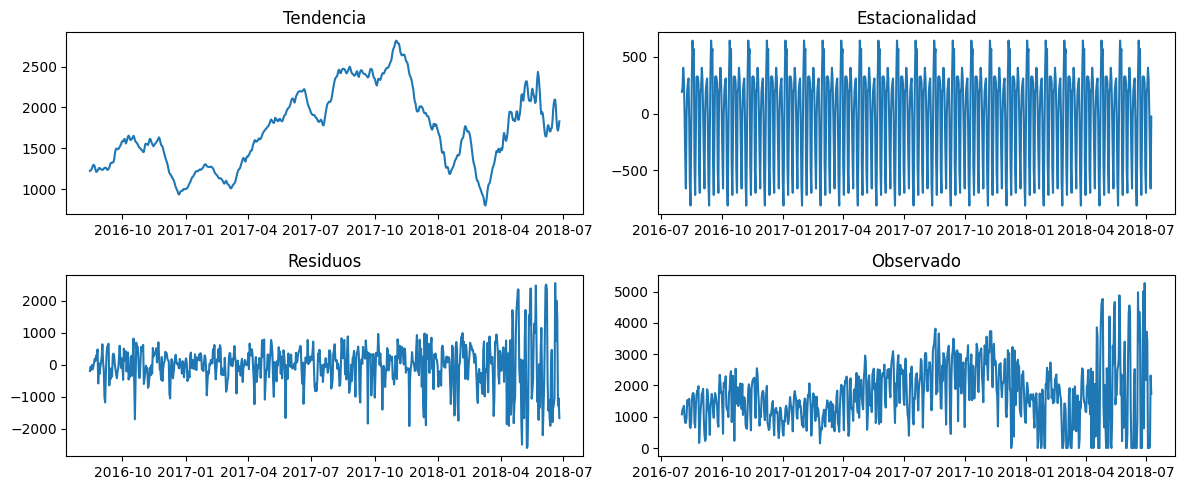

In [27]:
rents = df_shorten.set_index('date')
rents = rents.resample('D').bici_id_usuario.count()
daily_result = seasonal_decompose(rents, model='additive', period=28)

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.plot(daily_result.trend)
plt.title('Tendencia')

plt.subplot(2, 2, 2)
plt.plot(daily_result.seasonal)
plt.title('Estacionalidad')

plt.subplot(2, 2, 3)
plt.plot(daily_result.resid)
plt.title('Residuos')

plt.subplot(2, 2, 4)
plt.plot(daily_result.observed)
plt.title('Observado')

plt.tight_layout()
plt.show()

##### **Observacion**

* A partir de los gráficos podemos observar una tendencia creciente a partir de los meses de marzo y decreciente a partir de diciembre. 
* Observamos una clara estacionalidad en la serie que coincide con lo visto en los gráficos intrasemanales e intradiarios.
* El residual muestra un aumento en la varianza hacia el final de la serie temporal, lo que nos sugiere que los residuos pueden no seguir un proceso de ruido blanco. 

#### Extraer la tendencia y ajustar un modelo determinístico:
Explicar su relación con el contexto. Obtener conclusiones acerca de la validez del modelo.


In [28]:
# Extraemos tendencia calculada a partir de la cantidad de usuario por día (es decir NO tiempo de uso calculado en minutos)

tendencia = daily_result.trend

tendencia = tendencia.dropna()

x_data = np.arange(len(tendencia))
y_data = tendencia

##### **Observación:**
Como en el gráfico de la tendencia vemos períodos que presentan picos y valles, esto es varios minimos y máximos locales, decidimos fitear un modelo de coseno.
Los picos no necesariamente están a una distancia regular, pero sí vemos que la amplitud varía. 
A continuación definimos un modelo de **coseno**

In [29]:
# a = amplitud, b=frecuencia, c=fase, d=offset

def cosine_model(x, a, b, c, d):
    return a * np.cos(b * x + c) + d

In [30]:
''' Definimos los valores iniciales de los parámetros:
a (amplitud) = 0
b (frecuencia) = 2*np.pi/365
c (fase) = 0
d (offset) = np.mean(y_data)

'''

popt, pcov = curve_fit(cosine_model, x_data, y_data,  p0=(0, 2*np.pi/365, 0, np.mean(y_data)))
y_fit = cosine_model(x_data, *popt)

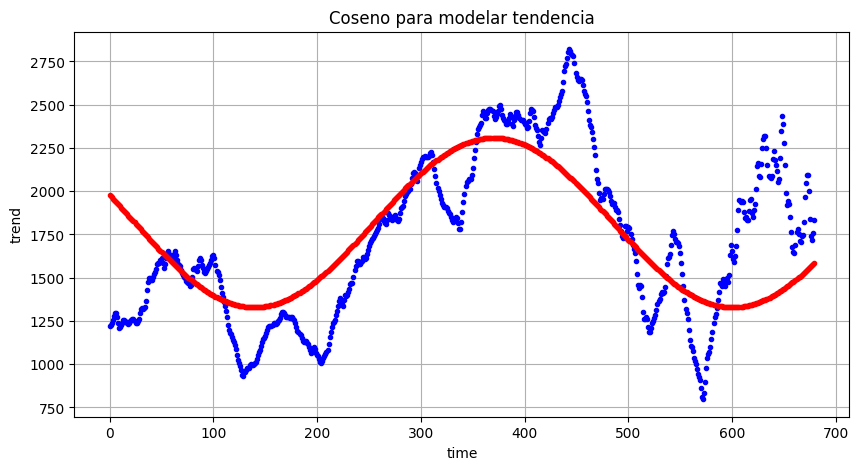

In [31]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('Coseno para modelar tendencia')  
plt.grid(True)

##### **Observacion** 

Podemos ver que la curva no pasa por la media en todos los puntos y qua hay mucha varianza hacia el final de la serie. 
Podríamos probar con otra familia de modelos o bien probar con un modelo de coseno con más parámetros como haremos a continuación:
de este modo tendremos dos cosenos diferentes, cada uno con su propia amplitud, frecuencia y fase
intradiarios e intrasemanales. 


In [32]:
def double_cosine_model(x, a, b, c, d, e, f, g):
    """"Función para fitear un modelo coseno con 7 parámetros:
    a = amplitud
    b = frecuencia
    c = fase
    d = offset
    e = amplitud
    f = frecuencia
    g = fase
    """
    return a * np.cos(b * x + c) + d + e * np.cos(f * x + g)

In [33]:
popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=(2500, 2*np.pi/365, 0, np.mean(y_data), 1, 2*np.pi/365*7, 0))
y_fit_double = double_cosine_model(x_data, *popt)


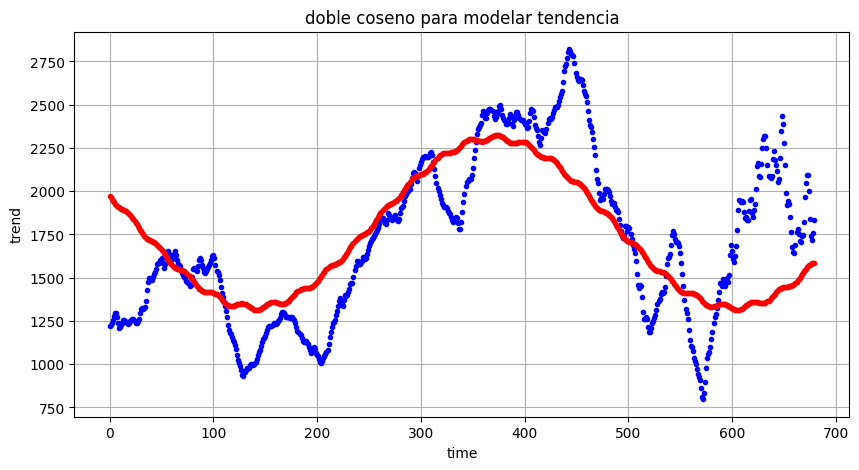

In [34]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_double, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('Doble coseno para modelar tendencia')  
plt.grid(True)

#### Realizamos una búsqueda de mejores hiperparámetros
Para cada combinación calculamos el RMSE

In [35]:
def rmse(x,y): return np.sqrt(((x-y)**2).mean())

best_rmse = None
best_sol = None

for i in range(1000):
    p0 = [np.random.randint(50, 5000), np.random.uniform(0.001, 0.5), np.random.random(), 
          np.random.randint(int(np.mean(y_data)/2),  int(np.mean(y_data)*2)), 
          np.random.randint(20, 1000), np.random.uniform(0.001, 0.75), np.random.random()]
    try:
        popt, pcov = curve_fit(double_cosine_model, x_data, y_data, p0=p0)
    except:
        continue

    y_fit = double_cosine_model(x_data, *popt)
    this_rmse = rmse(y_data, y_fit)
    if best_rmse is None or this_rmse < best_rmse:
        best_rmse = this_rmse
        best_sol = popt
        print("found better ", best_rmse)
    

found better  475.3507815440996
found better  475.2575939546401
found better  472.6495783705329
found better  472.39853636699473
found better  469.39920858144404
found better  330.15651402099195
found better  267.0128169402145


#### Predecimos con los mejores hiperparámetros, es decir la combinación que nos da el menor rmse

In [36]:
y_fit_best= double_cosine_model(x_data, *best_sol)

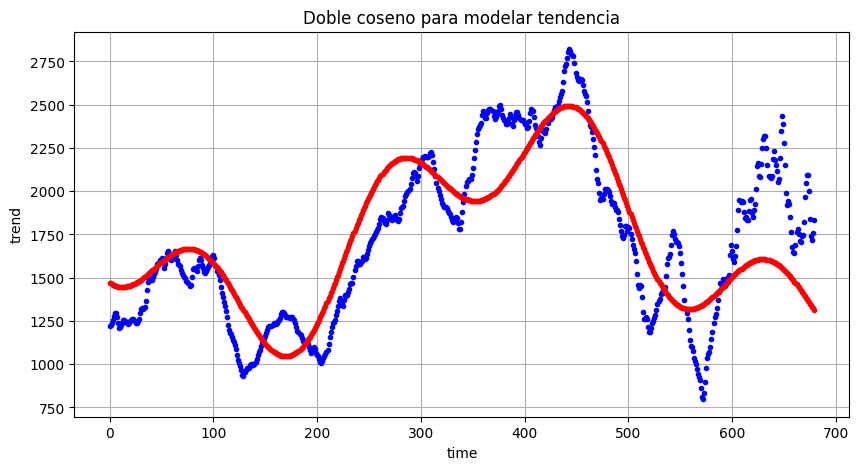

In [38]:
plt.figure(figsize=(10,5))
plt.plot(x_data, y_data, 'b.', label='original data')
plt.plot(x_data, y_fit_best, 'r.', label="fitted data")
plt.xlabel('time')
plt.ylabel('trend')
plt.title('Doble coseno para modelar tendencia')  
plt.grid(True)

##### **Observacion**
Con un doble coseno vemos que fitea un poco mejor, aun asi la curva no pasa bien por los puntos.

#### Evaluar si la serie es estacionaria

* Evaluar si la serie original es estacionaria.
* Aplicar transformaciones (preprocesamiento),
* Graficar autocorrelación, autocorrelación parcial y extraer conclusiones.


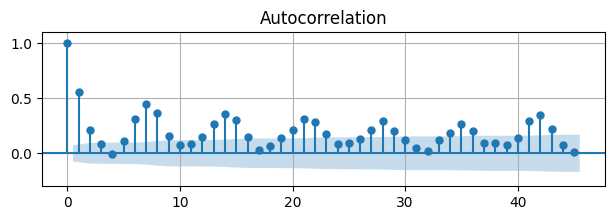

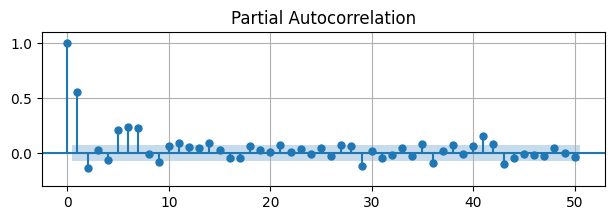

In [50]:
# autocorrelación 
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_acf(bicis_por_dia, lags=45, ax=plt.gca()) #lags=dias
plt.ylim(-0.3,1.1)
plt.grid(True)
plt.show()

# autocorrelación parcial
plt.figure(figsize=(16,2))
plt.subplot(1,2,2)
plot_pacf(bicis_por_dia, lags=50, ax=plt.gca()) #lags=dias
plt.ylim(-0.3,1.1)
plt.grid(True)
plt.show()

##### **Observacion** 

A partir de este gráfico de autocorrelación, podemos observar una clara autocorrelación  intrasemanal,que coincide con lo observado en los gráficos más arriba, donde se ve la tendencia semanal (con más alquileres durante los días de semana). Se observan picos correspondientes a ciclos de 24 horas. Observamos que el mejor lag = 7

#### Evaluamos estacionariedad: Test de Dickey Fuller 

In [51]:
adf_result = adfuller(bicis_por_dia)
print('estadistica:', adf_result[0])
print('p valor:', adf_result[1])
print('valores criticos:', adf_result[2])
for key, value in adf_result[4].items():
    print('critical values:')
    print(f' {key}, {value}')

estadistica: -3.3540409844748362
p valor: 0.012629017999786692
valores criticos: 13
critical values:
 1%, -3.4398077121659765
critical values:
 5%, -2.865713608066101
critical values:
 10%, -2.5689925469026402


##### **Observacion**

Aca lo que nos esta diciendo el test es que el p valor es <  0.05, lo cual  nos permite rechazar la hipotesis nula. Pero graficando la serie vemos que esto no es correcto. Por lo tanto asumimos que algunas de las hipotesis del test de dickey fuller no se estan cumpliendo con estos datos. Una de las asunciones del test de Dickey fuller es que las perturbaciones aleatorias en el modelo son ruido blanco. En el caso de la estacionariedad debil, se asume que la varianza es constante.

<Axes: xlabel='date'>

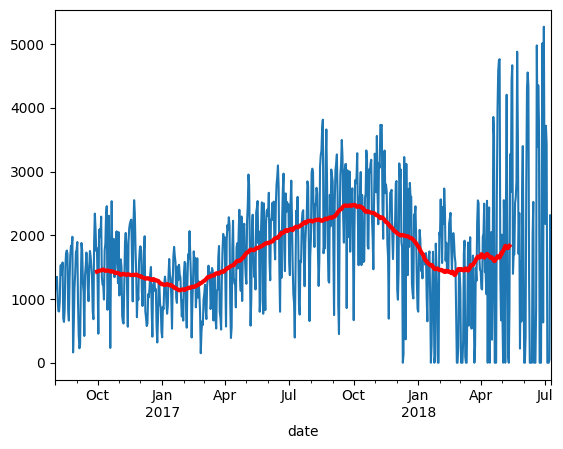

In [52]:
bicis_por_dia.plot()
bicis_por_dia.rolling(120, center=True).mean().dropna().plot(lw=3, color='r')

##### **Observacion**

Se ve mucho ruido a la derecha, o sea apartir de abril de 2018 (muchos ceros espureos). A ojo observamos que la serie no es estacionaria porque con una ventana deslizante de 120 dias vemos como la media va cambiando.

In [53]:
bicis_por_dia = df_shorten.groupby('date').bici_id_usuario.count().resample('D').sum()

<Axes: xlabel='date'>

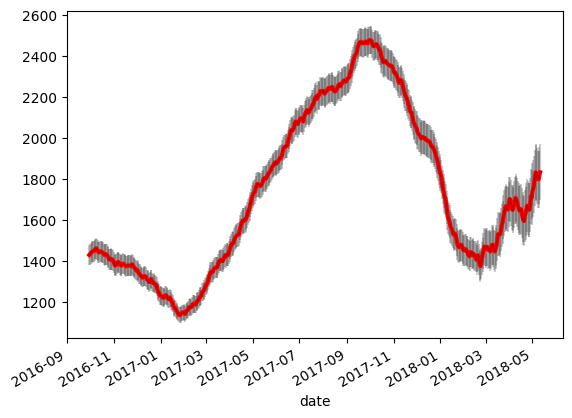

In [54]:
# Calculamos standard error = std / n**0.5

error = bicis_por_dia.rolling(120, center=True).std() / bicis_por_dia.rolling(120, center=True).count() ** 0.5
mean = bicis_por_dia.rolling(120, center=True).mean().dropna()
plt.errorbar(mean.index, mean.values, yerr=error.dropna().values, alpha=0.2, color='k')
mean.plot(color='r', lw=3)

##### **Observacion**

La diferencia parece ser bastante significativa.
Vamos a probar cortaando el dataset desde dic 2017 y ver que pasa.

In [71]:
df_trimmed = df_shorten[df_shorten['date'] <= pd.to_datetime('2017-12-01 23:59:59')].copy()
bicis_por_dia_trimmed = df_trimmed.groupby('date').bici_id_usuario.count().resample('D').sum()

In [76]:
bicis_por_dia_trimmed

date
2016-08-01    1077
2016-08-02    1233
2016-08-03    1249
2016-08-04    1348
2016-08-05    1008
              ... 
2017-11-27    2074
2017-11-28    2071
2017-11-29    2203
2017-11-30    2818
2017-12-01    2851
Freq: D, Name: bici_id_usuario, Length: 488, dtype: int64

#### Fiteamos un AR(7)
El valor 7 lo elegimos a partir de observar los graficos de acf y pacf

In [ ]:
lag_order = 7
model = AutoReg(bicis_por_dia_trimmed, lags=lag_order).fit()

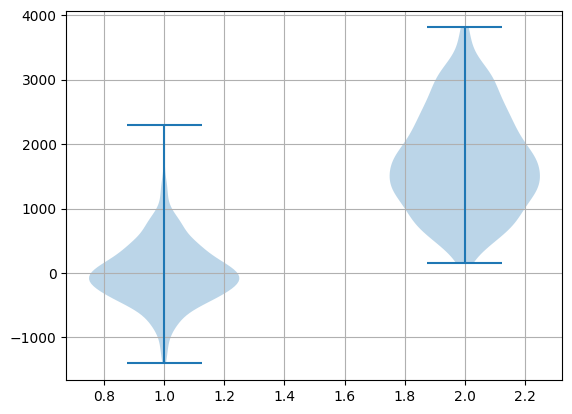

In [81]:
# ploteamos error
err_raw = model.predict() - bicis_por_dia_trimmed

plt.violinplot([err_raw.dropna(), bicis_por_dia_trimmed.dropna()])
plt.grid()



In [82]:
# Para calcular el error relativo, eliminamos los ceros que corresponden a 13 datapoints
mask = bicis_por_dia_trimmed > 0

In [83]:
percentiles = np.percentile((err_raw[mask] / bicis_por_dia_trimmed[mask]).dropna(), [25,50,75])
percentiles

array([-0.13584936, -0.0228191 ,  0.21956661])

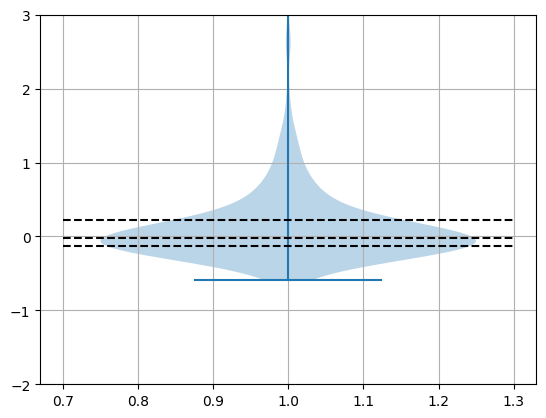

In [84]:
plt.violinplot((err_raw[mask] / bicis_por_dia_trimmed[mask]).dropna(), points=300)
plt.hlines(percentiles, 0.7, 1.3, color='k', linestyle='--')
plt.ylim(-2,3)
plt.grid()

##### **Observacion**

La mediana del error esta en -0.022, lo que significa que el 50% de las veces predice alrededor de 2.2% menos que la data real. 
El 25% de las veces predice por defecto por lo menos un 13% menos que la data real.
El 25% de las veces predice por exceso al menos un 21% mas que la data real. 


In [156]:
periodos = list(range(0,10))
p_values=[]

for i in periodos:
    bicis_diferenciada = bicis_por_dia_trimmed.diff(periods=i).dropna() if i else bicis_por_dia_trimmed
    adf_result = adfuller(bicis_diferenciada, )[1]
    p_values.append(adf_result)
    
    

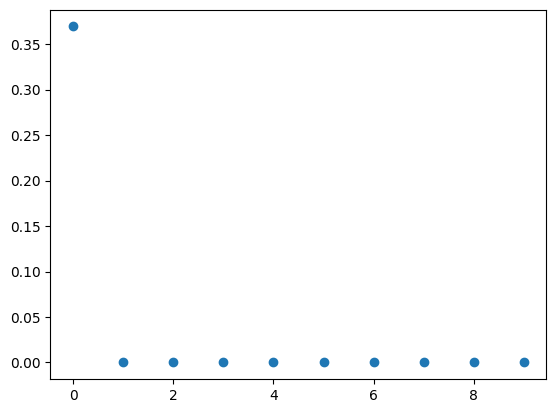

In [157]:
plt.scatter(periodos, p_values)
#plt.yscale('log')

In [158]:
p_values

[0.3694547591211714,
 4.4170208750273734e-15,
 3.511032558929837e-12,
 1.0790062649603084e-08,
 2.8688810723851876e-08,
 2.5980414979239254e-08,
 1.9691694115631234e-06,
 6.716239578802833e-09,
 2.6334757288854338e-09,
 6.729682282822446e-10]

##### **Observacion**

La lista p_values contiene los valores p obtenidos de la prueba de Dickey-Fuller para cada numero de diferenciaciones.
Como podemos observar con una sola diferenciacion es suficiente para hacer la serie estacionaria.
Si no diferenciamos vemos que el p valor es 0,36 o sea que no podemos rechazar la hipotesis nula, por lo tanto NO ES ESTACIONARIA.
Solo habiendo recortado desde la parte de dic 2017 en adelante pudimos llegar a esta conclusion, ya que antes se rompia la hipotesis del residual y el test nos daba un FP, es decir daba significativo cuando no lo era. 



### Ajuste de modelos 

* A partir de las transformaciones propuestas ajustar distintos modelos (S)ARIMA. Extraer orden, parámetros, coeficientes numéricos y análisis de la bondad del modelo.
* Ajustar y predecir usando redes neuronales LSTM. Comparar con predicciones usando SARIMA y extraer conclusiones.
* Reailzar el análisis espectral de la serie original. Hallar las frecuencias principales y comparar con las componentes cíclica y estacional usando la descomposición.

In [159]:
#Fiteamos un MA


order = 7 
ma_model = ARIMA(bicis_por_dia_trimmed, order=(0, 0, order)).fit()
ma_model.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:        bici_id_usuario   No. Observations:                  488
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -3769.978
Date:                Sat, 06 Apr 2024   AIC                           7557.957
Time:                        15:01:51   BIC                           7595.669
Sample:                    08-01-2016   HQIC                          7572.770
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1736.9405     67.654     25.674      0.000    1604.342    1869.539
ma.L1          0.5541      0.036     15.322      0.000       0.483       0.625
ma.L2          0.1521      0.045      3.410      0.001       0.065       0.239
ma.L3          0.0572      0.045      1.272      0.203      -0.031       0.145
ma.L4          0.0483      0.047      1.037      0.300      -0.043       0.140
ma.L5          0.1355      0.045      3.016      0.003       0.047       0.224
ma.L6          0.2889      0.044      6.527      0.000       0.202       0.376
ma.L7          0.3815      0.044      8.630      0.000       0.295       0.468
sigma2      2.995e+05   1.95e+04     15.349      0.000    2.61e+05    3.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.46   Jarque-Bera (JB):                 2.02
Prob(Q):                              0.03   Prob(JB):                         0.37
Heteroskedasticity (H):               2.14   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from time import time

def plotARMA(series,ax):
    mod = sm.tsa.ARIMA(series, order=(7,1,7), missing='raise').fit()
    series.plot(ax=ax,label="datos")
    mod.predict()[1:].plot(ax=ax,label="modelo")
    return mod

fig,ax = plt.subplots(figsize=(10,3))    
t0 = time()
arima = plotARMA(bicis_por_dia_trimmed,ax)
arima_time = time() - t0

plt.legend(fontsize=8)
plt.title("ARIMA")
plt.show()

arima_time

/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           23     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.45849D+00    |proj g|=  6.64064D-01


 This problem is unconstrained.



At iterate    5    f=  7.17020D+00    |proj g|=  8.93716D-02

At iterate   10    f=  7.15036D+00    |proj g|=  6.17532D-02

At iterate   15    f=  7.14599D+00    |proj g|=  1.67591D-02

At iterate   20    f=  7.14427D+00    |proj g|=  1.23524D-02

At iterate   25    f=  7.14352D+00    |proj g|=  2.05277D-02

At iterate   30    f=  7.14290D+00    |proj g|=  2.05668D-02

At iterate   35    f=  7.14270D+00    |proj g|=  1.72659D-02

At iterate   40    f=  7.14258D+00    |proj g|=  2.82936D-02

At iterate   45    f=  7.14243D+00    |proj g|=  9.07645D-03


/Users/marianata/miniconda3/envs/obesity_risk/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.14239D+00    |proj g|=  1.88282D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   23     50     54      1     0     0   1.883D-02   7.142D+00
  F =   7.1423906014471399     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


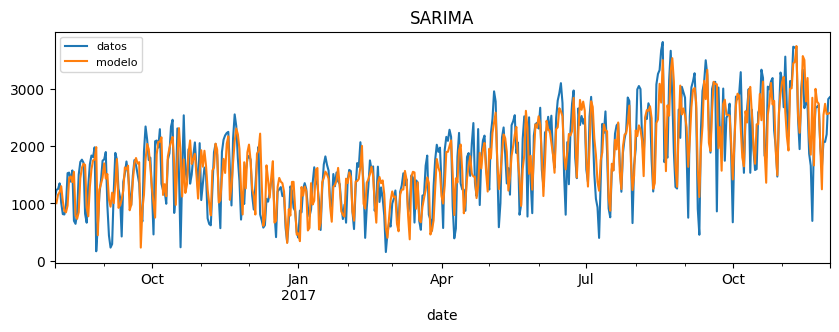

In [172]:
def plotSARIMA(series,ax):
    mod = sm.tsa.SARIMAX(series, order=(7,1,7), seasonal_order=(4,1,4,28),  missing='raise').fit()
    series.plot(ax=ax,label="datos")
    mod.predict()[1:].plot(ax=ax,label="modelo")
    return mod

fig,ax = plt.subplots(figsize=(10,3))    
t0 = time()

sarima = plotSARIMA(bicis_por_dia_trimmed,ax)
sarima_time = time() - t0

plt.legend(fontsize=8)
plt.title("SARIMA")
plt.show()

sarima_time

seasonal order 4 = 4 meses, s = 28 porque cada ciclo tiene 28 dias 

In [173]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                           SARIMAX Results                                           
=====================================================================================================
Dep. Variable:                               bici_id_usuario   No. Observations:                  488
Model:             SARIMAX(7, 1, 7)x(4, 1, [1, 2, 3, 4], 28)   Log Likelihood               -3485.487
Date:                                       Sat, 06 Apr 2024   AIC                           7016.973
Time:                                               15:23:04   BIC                           7111.941
Sample:                                           08-01-2016   HQIC                          7054.373
                                                - 12-01-2017                                         
Covariance Type:                                         opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4538      0.972     -0.467      0.641      -2.359       1.451
ar.L2         -0.3537      0.935     -0.378      0.705      -2.185       1.478
ar.L3         -0.3799      1.053     -0.361      0.718      -2.444       1.684
ar.L4         -0.3048      0.860     -0.354      0.723      -1.991       1.381
ar.L5          0.2287      0.973      0.235      0.814      -1.678       2.135
ar.L6          0.4219      0.626      0.674      0.500      -0.804       1.648
ar.L7         -0.2776      0.289     -0.960      0.337      -0.844       0.289
ma.L1         -0.0551      0.979     -0.056      0.955      -1.974       1.864
ma.L2         -0.1586      0.968     -0.164      0.870      -2.056       1.739
ma.L3          0.0002      0.969      0.000      1.000      -1.899       1.900
ma.L4         -0.0735      0.848     -0.087      0.931      -1.736       1.589
ma.L5         -0.4979      0.831     -0.599      0.549      -2.126       1.131
ma.L6         -0.4049      0.838     -0.483      0.629      -2.048       1.238
ma.L7          0.5584      0.761      0.733      0.463      -0.934       2.051
ar.S.L28      -1.0470      9.668     -0.108      0.914     -19.996      17.902
ar.S.L56      -0.9526      4.141     -0.230      0.818      -9.069       7.164
ar.S.L84      -0.4457      5.387     -0.083      0.934     -11.005      10.113
ar.S.L112     -0.0631      0.620     -0.102      0.919      -1.279       1.153
ma.S.L28       0.2028      9.650      0.021      0.983     -18.710      19.116
ma.S.L56       0.1112      6.017      0.018      0.985     -11.682      11.905
ma.S.L84      -0.2490      4.480     -0.056      0.956      -9.029       8.531
ma.S.L112     -0.1999      3.383     -0.059      0.953      -6.830       6.430
sigma2      3.412e+05   3.34e+04     10.226      0.000    2.76e+05    4.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               218.68
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.88   Skew:                            -0.91
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
tradeoff

tiempo de computo vs mejora en la prediccion

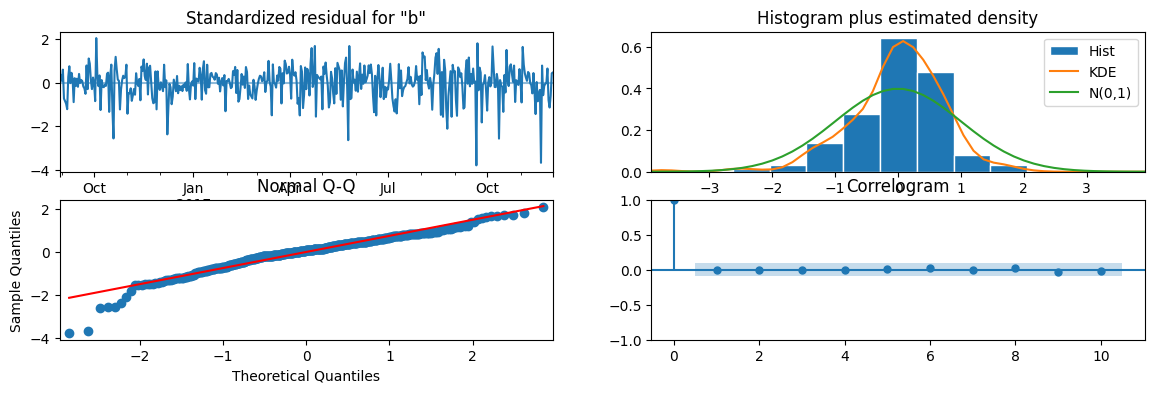

In [177]:
sarima.plot_diagnostics(figsize=(14, 4))
plt.show()

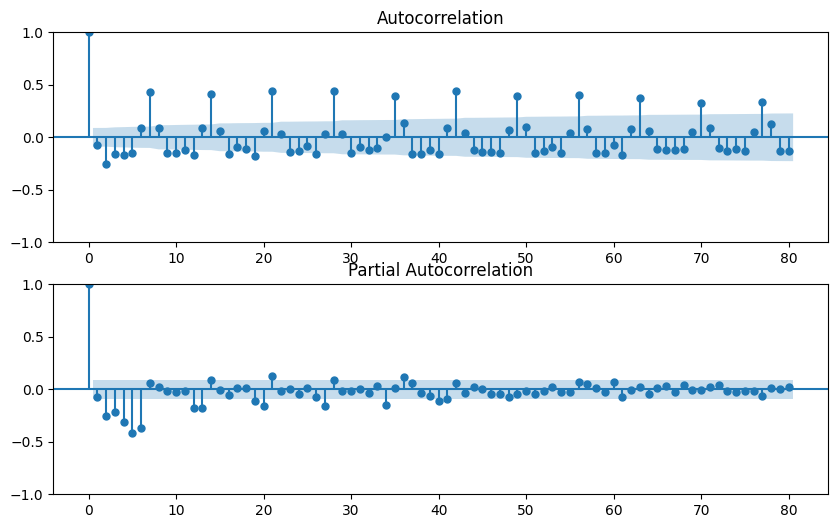

In [192]:
# Differencing to remove non-seasonal component
bicis_diff = bicis_por_dia_trimmed.diff().dropna()

# Plot the ACF and PACF of the differenced time series
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(bicis_diff, lags=80, ax=axes[0])
plot_pacf(bicis_diff, lags=80, ax=axes[1])
plt.show()

# SARIMA order parameters
p = ??  # Autoregressive order
d = ??  # Differencing order
q = ??  # Moving average order
P = ??  # Seasonal autoregressive order
D = ??  # Seasonal differencing order
Q = ??  # Seasonal moving average order
s = ??  # Seasonal period

# Fit SARIMA model
sarima_model = sm.tsa.SARIMAX(daily_rentals, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_results = sarima_model.fit()
